In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score,balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score



### Reading Data

In [3]:
df = pd.read_csv('processedData.csv', index_col=[0])
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
0,5,261,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,5,149,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,3,226,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,3,151,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,5,307,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,334,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41184,4,383,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41185,5,189,2,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41186,4,442,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0


In [4]:
def converty(x):
    if x=='yes':
        return 1
    return 0

y = df['y']
y = y.apply(converty)
X = df.drop(columns=['y'])

### Splitting data into test and train

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

### Standardized data

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### SMOTE Oversampled data

In [7]:
# Create an oversampled training data
smote = SMOTE(random_state = 17)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

### Classification Report Plot function

In [8]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            ax.text(column,row,matrix[row][column],va='center',ha='center')

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

### ROC Curve Plot function

In [9]:
def ROC_function(model,X_test,y_test):
    noskill_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    prob = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob = prob[:, 1]
    # calculate scores
    noskill_auc = roc_auc_score(y_test, noskill_probs)
    auc = roc_auc_score(y_test, prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (noskill_auc))
    print('RF: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    noskill_fpr, noskill_tpr, _ = roc_curve(y_test, noskill_probs)
    fpr, tpr, _ = roc_curve(y_test, prob)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(noskill_fpr, noskill_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='RF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Random Forest

* ### Random Forest on Imbalanced Data

In [10]:
#Training with imbalance data
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=12)

In [11]:
rf_pred = rf_model.predict(X_test)

In [12]:
rf_acc = round(metrics.accuracy_score(y_test, rf_pred)*100, 2)
rf_bacc = round(metrics.balanced_accuracy_score(y_test, rf_pred)*100, 2)

print(f"Accuracy: {rf_acc}%")
print(f"Balanced Accuracy: {rf_bacc}%")

Accuracy: 91.41%
Balanced Accuracy: 71.57%


In [13]:
rf_cm = confusion_matrix(y_test, rf_pred)
print(rf_cm)


[[7100  203]
 [ 504  428]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

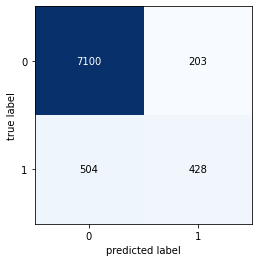

In [14]:
plot_confusion_matrix(rf_cm)

In [15]:
rf_classification_report = classification_report(y_test, rf_pred)
print(rf_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.68      0.46      0.55       932

    accuracy                           0.91      8235
   macro avg       0.81      0.72      0.75      8235
weighted avg       0.90      0.91      0.91      8235



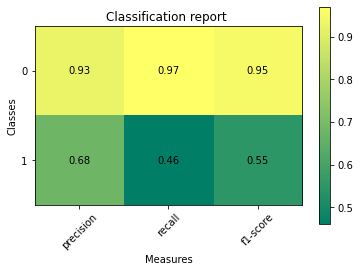

In [16]:
rf_cr = """       precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.68      0.46      0.55       932

    accuracy                           0.91      8235
   macro avg       0.81      0.72      0.75      8235
weighted avg       0.90      0.91      0.91      8235"""

plot_classification_report(rf_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.943


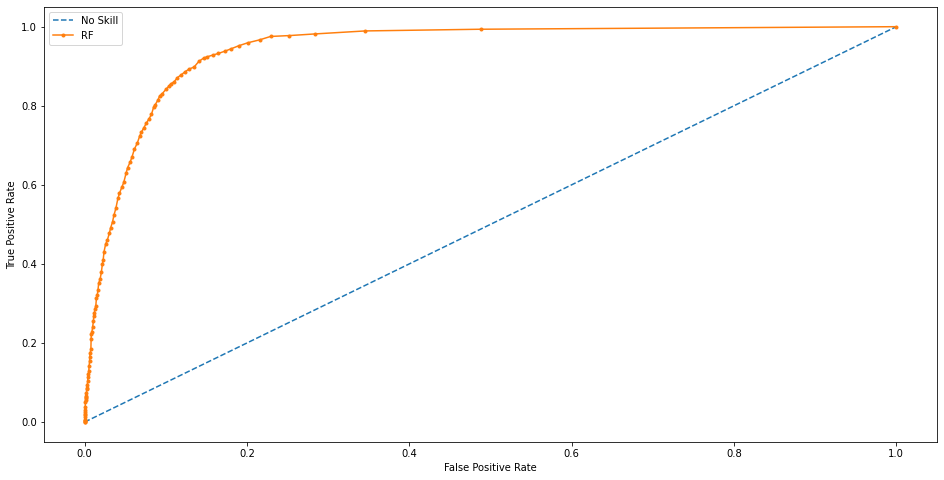

In [17]:
ROC_function(rf_model, X_test, y_test)

In [98]:
rf_f1 = f1_score(y_test, rf_pred, average=None)
rf_f1

array([0.95257262, 0.54766475])

* ### Random Forest on SMOTE Data

In [18]:
rf_smote = RandomForestClassifier(random_state=12)
rf_smote.fit(X_SMOTE, y_SMOTE)

RandomForestClassifier(random_state=12)

In [19]:
rf_smote_pred = rf_smote.predict(X_test)

In [20]:
rf_smote_acc = round(metrics.accuracy_score(y_test, rf_smote_pred)*100, 2)
rf_smote_bacc = round(metrics.balanced_accuracy_score(y_test, rf_smote_pred)*100, 2)

print(f"Accuracy: {rf_smote_acc}%")
print(f"Balanced Accuracy: {rf_smote_bacc}%")

Accuracy: 91.2%
Balanced Accuracy: 73.93%


In [21]:
rf_smote_cm = confusion_matrix(y_test, rf_smote_pred)
print(rf_smote_cm)

[[7029  274]
 [ 451  481]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

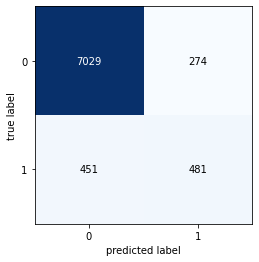

In [22]:
plot_confusion_matrix(rf_smote_cm)

In [23]:
rfsmote_classification_report = classification_report(y_test, rf_smote_pred)
print(rfsmote_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.64      0.52      0.57       932

    accuracy                           0.91      8235
   macro avg       0.79      0.74      0.76      8235
weighted avg       0.91      0.91      0.91      8235



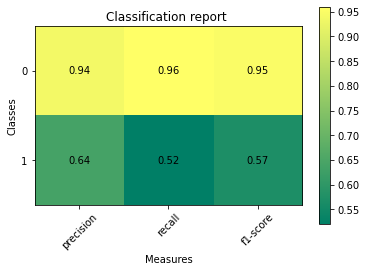

In [24]:
rf_smote_cr = """        precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.64      0.52      0.57       932

    accuracy                           0.91      8235
   macro avg       0.79      0.74      0.76      8235
weighted avg       0.91      0.91      0.91      8235"""

plot_classification_report(rf_smote_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.943


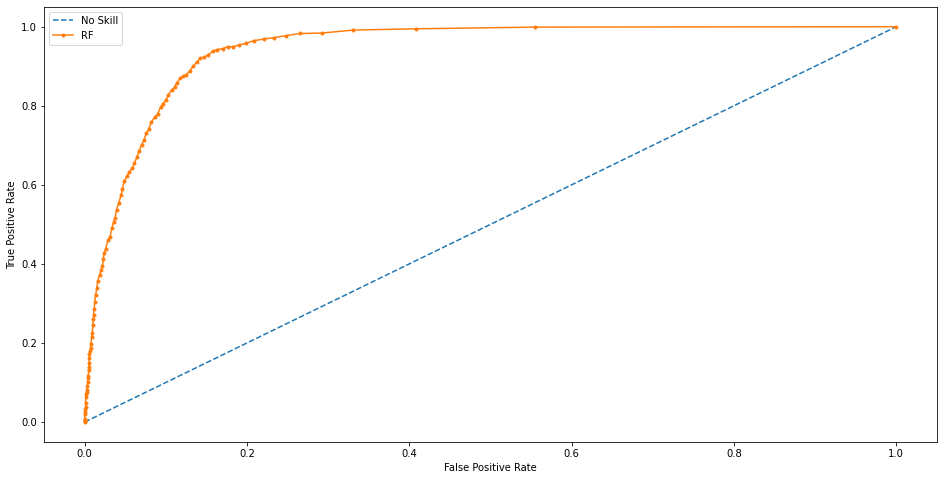

In [25]:
ROC_function(rf_smote, X_test, y_test)

In [99]:
rf_smote_f1 = f1_score(y_test, rf_smote_pred, average=None)
rf_smote_f1

array([0.95095718, 0.57024303])

* ### Random Forest Optimized

#### Hyper-parameters tuning

In [27]:
criterion = ['gini','entropy']
n_estimators = [100, 200, 500]
max_depth = [3, 5, 8]
max_features = [4, 6, 8]
min_samples_leaf = [1, 2, 4]

hyperF = dict( criterion = criterion, n_estimators = n_estimators, max_depth = max_depth,  
               max_features = max_features, min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf_smote, hyperF, cv = 4, n_jobs = -1, scoring = 'balanced_accuracy')
smote_best_param_rf = gridF.fit(X_SMOTE, y_SMOTE)

In [28]:
smote_best_param_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 6,
 'min_samples_leaf': 2,
 'n_estimators': 100}

#### Model

In [10]:
rf_tuned = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 8, max_features = 6, min_samples_leaf=2, random_state=12)
rf_tuned.fit(X_SMOTE, y_SMOTE)


RandomForestClassifier(criterion='entropy', max_depth=8, max_features=6,
                       min_samples_leaf=2, random_state=12)

In [11]:
rf_tuned_pred = rf_tuned.predict(X_test)

In [12]:
rf_tuned_acc = round(metrics.accuracy_score(y_test, rf_tuned_pred)*100, 2)
rf_tuned_bacc = round(metrics.balanced_accuracy_score(y_test, rf_tuned_pred)*100, 2)

print(f"Accuracy: {rf_tuned_acc}%")
print(f"Balanced Accuracy: {rf_tuned_bacc}%")

Accuracy: 88.59%
Balanced Accuracy: 79.57%


In [13]:
rf_tuned_cm = confusion_matrix(y_test, rf_tuned_pred)
print(rf_tuned_cm)

[[6662  641]
 [ 299  633]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

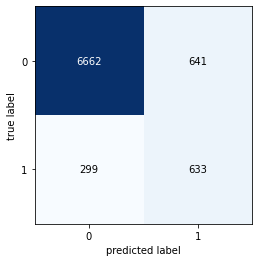

In [14]:
plot_confusion_matrix(rf_tuned_cm)

In [15]:
rftuned_classification_report = classification_report(y_test, rf_tuned_pred)
print(rftuned_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7303
           1       0.50      0.68      0.57       932

    accuracy                           0.89      8235
   macro avg       0.73      0.80      0.75      8235
weighted avg       0.90      0.89      0.89      8235



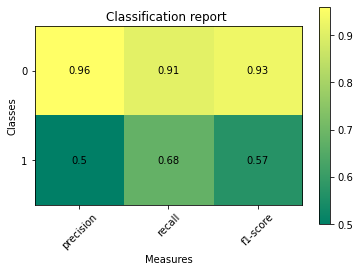

In [16]:
rf_tuned_cr = """    precision    recall  f1-score   support

           0       0.96      0.91      0.93      7303
           1       0.50      0.68      0.57       932

    accuracy                           0.89      8235
   macro avg       0.73      0.80      0.75      8235
weighted avg       0.90      0.89      0.89      8235"""

plot_classification_report(rf_tuned_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.932


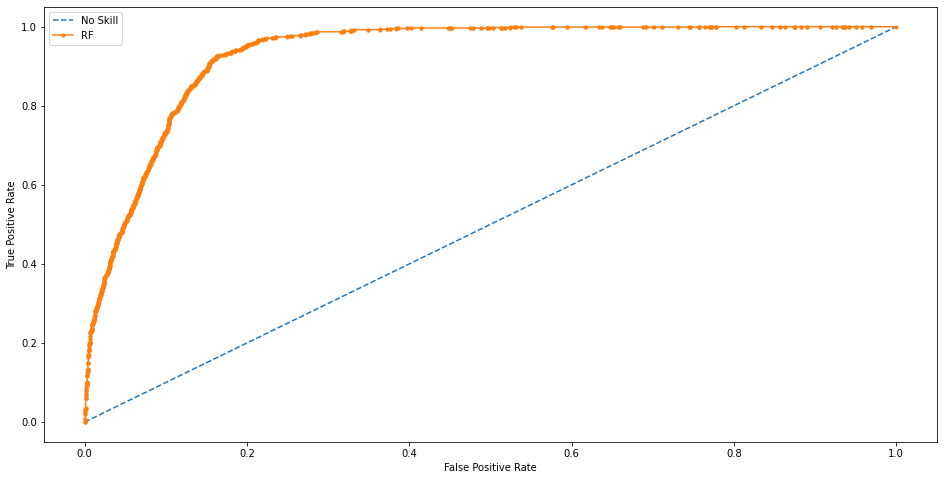

In [90]:
ROC_function(rf_tuned, X_test, y_test)

In [100]:
rf_tuned_f1 = f1_score(y_test, rf_tuned_pred, average=None)
rf_tuned_f1

array([0.93409983, 0.57388939])

### Feature Importance from best model

In [17]:
feature_imp = pd.Series(rf_tuned.feature_importances_,index=X_SMOTE.columns).sort_values(ascending=False)
feature_imp

duration                         2.520960e-01
euribor3m                        7.058493e-02
emp.var.rate                     6.945866e-02
nr.employed                      6.661586e-02
pdays                            6.652612e-02
contact_telephone                4.001977e-02
cons.conf.idx                    3.891504e-02
month_may                        2.867870e-02
cons.price.idx                   2.810594e-02
poutcome_nonexistent             2.533724e-02
job_blue-collar                  2.399558e-02
day_of_week_mon                  2.106586e-02
marital_married                  2.019121e-02
housing_yes                      1.992371e-02
housing_no                       1.886621e-02
poutcome_failure                 1.767788e-02
education_high.school            1.520204e-02
day_of_week_fri                  1.311693e-02
day_of_week_tue                  1.227932e-02
marital_divorced                 1.163376e-02
contact_cellular                 1.155427e-02
job_admin.                       1

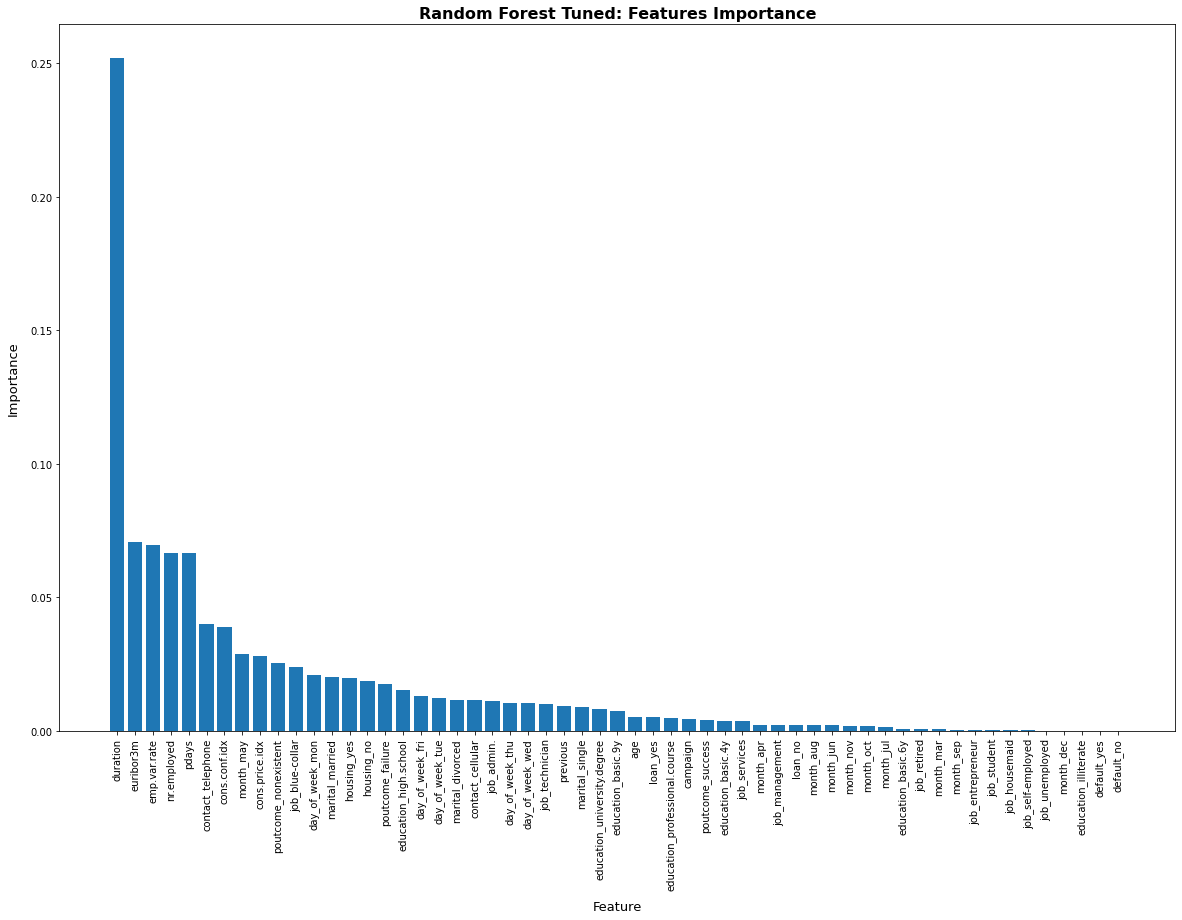

In [28]:
importance = feature_imp
plt.figure(figsize=(20,13))
plt.bar(feature_imp.index, importance)
plt.xticks(rotation='vertical')
plt.title('Random Forest Tuned: Features Importance', fontweight='bold', size=16)
plt.ylabel('Importance', size=13, labelpad = 10)
plt.xlabel('Feature', size=13, labelpad = 10)
plt.show()

## Gradient Boosting Machine

* ### GBM on Imbalanced Data

In [52]:
gbm_model = GradientBoostingClassifier(random_state = 12)
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=12)

In [53]:
gbm_pred = gbm_model.predict(X_test)

In [54]:
gbm_acc = round(metrics.accuracy_score(y_test, gbm_pred)*100, 2)
gbm_bacc = round(metrics.balanced_accuracy_score(y_test, gbm_pred)*100, 2)

print(f"Accuracy: {gbm_acc}%")
print(f"Balanced Accuracy: {gbm_bacc}%")

Accuracy: 91.68%
Balanced Accuracy: 75.05%


In [55]:
gbm_cm = confusion_matrix(y_test, gbm_pred)
print(gbm_cm)


[[7051  252]
 [ 433  499]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

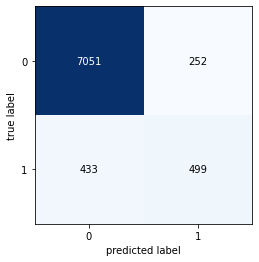

In [56]:
plot_confusion_matrix(gbm_cm)

In [57]:
gbm_classification_report = classification_report(y_test, gbm_pred)
print(gbm_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.66      0.54      0.59       932

    accuracy                           0.92      8235
   macro avg       0.80      0.75      0.77      8235
weighted avg       0.91      0.92      0.91      8235



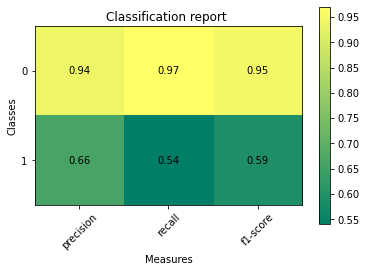

In [58]:
gbm_cr = """             precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.66      0.54      0.59       932

    accuracy                           0.92      8235
   macro avg       0.80      0.75      0.77      8235
weighted avg       0.91      0.92      0.91      8235"""

plot_classification_report(gbm_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.949


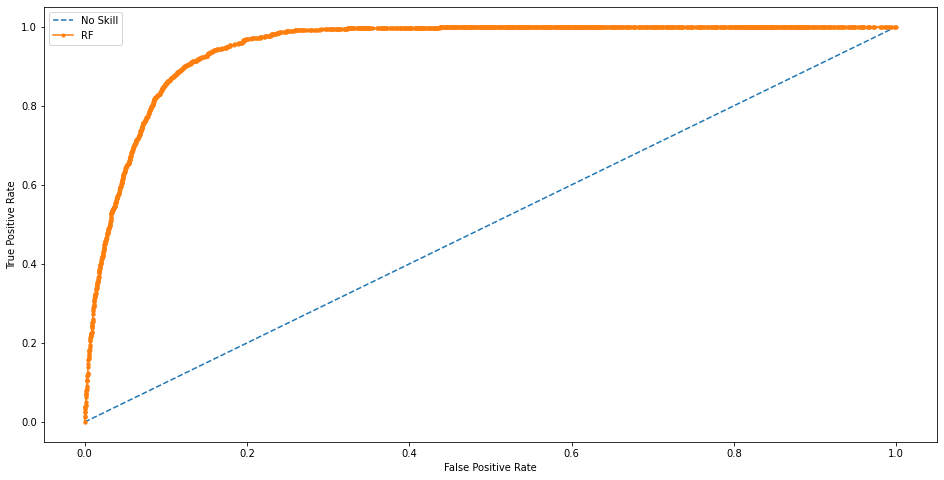

In [59]:
ROC_function(gbm_model, X_test, y_test)

In [101]:
gbm_f1 = f1_score(y_test, gbm_pred, average=None)
gbm_f1 

array([0.95367553, 0.59298871])

* ### GBM on SMOTE Data

In [29]:
gbm_smote_model = GradientBoostingClassifier(random_state = 12)
gbm_smote_model.fit(X_SMOTE, y_SMOTE)

GradientBoostingClassifier(random_state=12)

In [30]:
gbm_smote_pred = gbm_smote_model.predict(X_test)

In [31]:
gbm_smote_acc = round(metrics.accuracy_score(y_test, gbm_smote_pred)*100, 2)
gbm_smote_bacc = round(metrics.balanced_accuracy_score(y_test, gbm_smote_pred)*100, 2)

print(f"Accuracy: {gbm_smote_acc}%")
print(f"Balanced Accuracy: {gbm_smote_bacc}%")

Accuracy: 90.66%
Balanced Accuracy: 78.4%


In [32]:
gbm_smote_cm = confusion_matrix(y_test, gbm_smote_pred)
print(gbm_smote_cm)


[[6883  420]
 [ 349  583]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

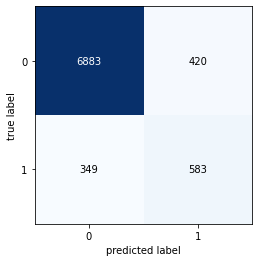

In [33]:
plot_confusion_matrix(gbm_smote_cm)

In [34]:
gbm_smote_classification_report = classification_report(y_test, gbm_smote_pred)
print(gbm_smote_classification_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7303
           1       0.58      0.63      0.60       932

    accuracy                           0.91      8235
   macro avg       0.77      0.78      0.77      8235
weighted avg       0.91      0.91      0.91      8235



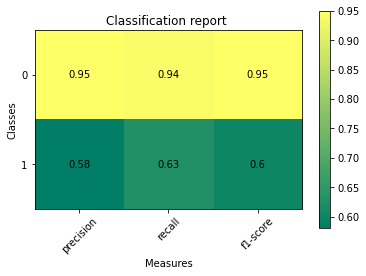

In [66]:
gbm_smote_cr = """    precision    recall  f1-score   support

           0       0.95      0.94      0.95      7303
           1       0.58      0.63      0.60       932

    accuracy                           0.91      8235
   macro avg       0.77      0.78      0.77      8235
weighted avg       0.91      0.91      0.91      8235"""

plot_classification_report(gbm_smote_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.943


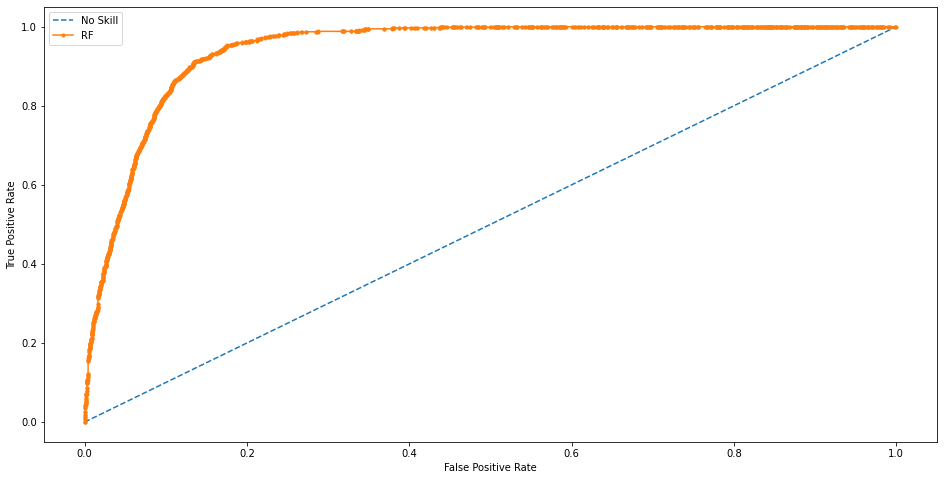

In [67]:
ROC_function(gbm_smote_model, X_test, y_test)

In [102]:
gbm_smote_f1 = f1_score(y_test, gbm_smote_pred, average=None)
gbm_smote_f1

array([0.94709322, 0.60258398])

* ### GBM Optimized

#### Hyper-parameters tuning

In [69]:
n_estimators = [100,200,500]
max_depth = [3, 5, 8]
max_features = [7,9]
min_samples_leaf =[1,2,4]

paramgrid_gbm = dict(n_estimators = n_estimators, max_depth = max_depth,  
               max_features = max_features,min_samples_leaf=min_samples_leaf)

grid_gbm = GridSearchCV(gbm_smote_model, paramgrid_gbm, cv = 4,n_jobs = -1,scoring = 'balanced_accuracy')
smote_best_param_gbm = grid_gbm.fit(X_SMOTE, y_SMOTE)

In [70]:
smote_best_param_gbm.best_params_

{'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 100}

#### Model

In [71]:
gbm_tuned = GradientBoostingClassifier(n_estimators=100, max_depth = 8, max_features = 7, min_samples_leaf = 1, random_state=12)
gbm_tuned.fit(X_SMOTE, y_SMOTE)


GradientBoostingClassifier(max_depth=8, max_features=7, random_state=12)

In [72]:
gbm_tuned_pred = gbm_tuned.predict(X_test)

In [73]:
gbm_tuned_acc = round(metrics.accuracy_score(y_test, gbm_tuned_pred)*100, 2)
gbm_tuned_bacc = round(metrics.balanced_accuracy_score(y_test, gbm_tuned_pred)*100, 2)

print(f"Accuracy: {gbm_tuned_acc}%")
print(f"Balanced Accuracy: {gbm_tuned_bacc}%")

Accuracy: 91.18%
Balanced Accuracy: 74.9%


In [74]:
gbm_tuned_cm = confusion_matrix(y_test, gbm_tuned_pred)
print(gbm_tuned_cm)

[[7007  296]
 [ 430  502]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

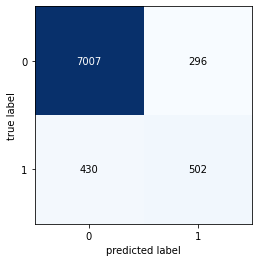

In [75]:
plot_confusion_matrix(gbm_tuned_cm)

In [76]:
gbm_tuned_classification_report = classification_report(y_test, gbm_tuned_pred)
print(gbm_tuned_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.63      0.54      0.58       932

    accuracy                           0.91      8235
   macro avg       0.79      0.75      0.77      8235
weighted avg       0.91      0.91      0.91      8235



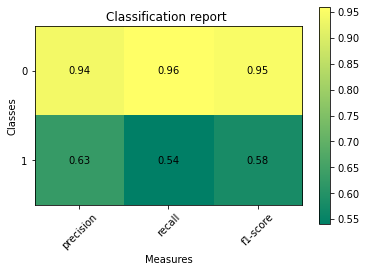

In [77]:
gbm_tuned_cr = """    precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.63      0.54      0.58       932

    accuracy                           0.91      8235
   macro avg       0.79      0.75      0.77      8235
weighted avg       0.91      0.91      0.91      8235"""

plot_classification_report(gbm_tuned_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.945


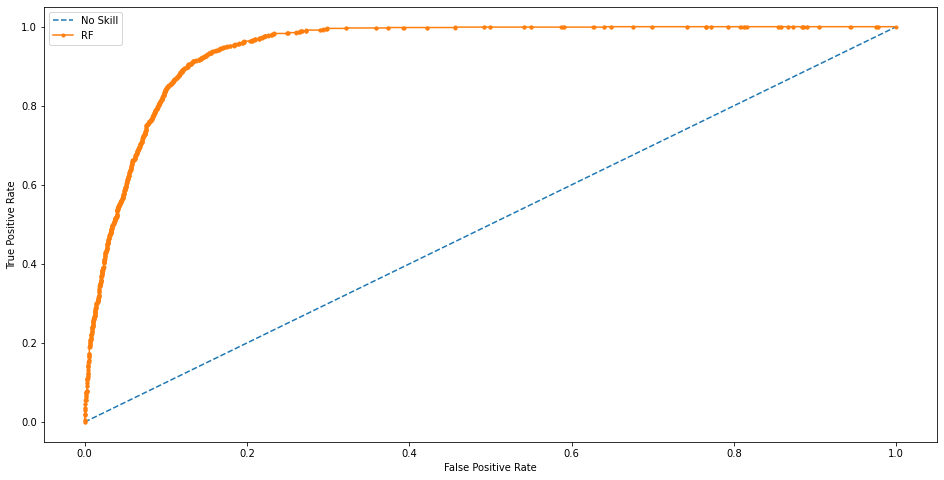

In [78]:
ROC_function(gbm_tuned, X_test, y_test)

In [103]:
gbm_tuned_f1 = f1_score(y_test, gbm_tuned_pred, average=None)
gbm_tuned_f1

array([0.95074627, 0.58034682])

### Features Importance based on best model (gbm_smote_model)

In [35]:
feature_imp_gbm = pd.Series(gbm_smote_model.feature_importances_,index=X_SMOTE.columns).sort_values(ascending=False)
feature_imp_gbm

duration                         0.360066
nr.employed                      0.221563
cons.conf.idx                    0.068917
pdays                            0.039445
contact_telephone                0.031951
euribor3m                        0.025577
housing_yes                      0.023373
marital_divorced                 0.021947
emp.var.rate                     0.019839
marital_single                   0.015583
day_of_week_mon                  0.015508
day_of_week_thu                  0.014391
job_blue-collar                  0.014060
marital_married                  0.011658
poutcome_failure                 0.011281
day_of_week_fri                  0.010983
day_of_week_tue                  0.010579
day_of_week_wed                  0.010553
education_high.school            0.010347
month_may                        0.007033
education_university.degree      0.006213
housing_no                       0.005945
job_admin.                       0.005480
education_basic.4y               0

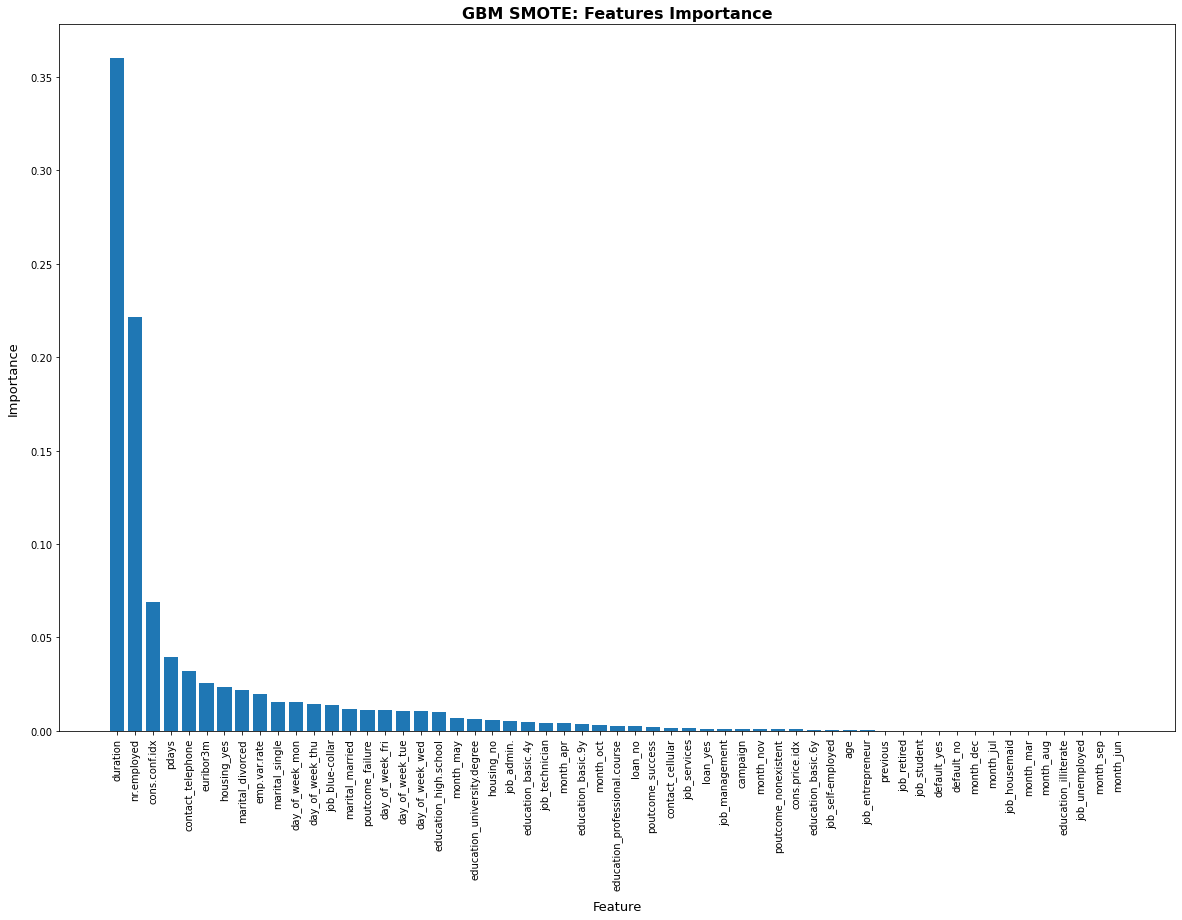

In [36]:
importance = feature_imp_gbm
plt.figure(figsize=(20,13))
plt.bar(feature_imp_gbm.index, importance)
plt.xticks(rotation='vertical')
plt.title('GBM SMOTE: Features Importance', fontweight='bold', size=16)
plt.ylabel('Importance', size=13, labelpad = 10)
plt.xlabel('Feature', size=13, labelpad = 10)
plt.show()

## Final Results:

In [105]:
models = ['Random Forest: Imbalanced Data', 'Random Forest: SMOTE Data', 'Random Forest: Optimized', 'GBM: Imbalanced Data', 'GBM: SMOTE Data', 'GBM: Optimized']
accs = [rf_acc, rf_smote_acc, rf_tuned_acc, gbm_acc, gbm_smote_acc, gbm_tuned_acc]
baccs = [rf_bacc, rf_smote_bacc, rf_tuned_bacc, gbm_bacc, gbm_smote_bacc, gbm_tuned_bacc]
f1_scores = [rf_f1[1], rf_smote_f1[1], rf_tuned_f1[1], gbm_f1[1], gbm_smote_f1[1], gbm_tuned_f1[1]] 

modelsInfo = {'Models': models, 'Accuracies': accs, 'Balanced Accuracies': baccs, 'f1-Scores': f1_scores}

modelsDf = pd.DataFrame(modelsInfo)
modelsDf

,Models,Accuracies,Balanced Accuracies,f1-Scores
0,Random Forest: Imbalanced Data,91.41,71.57,0.547665
1,Random Forest: SMOTE Data,91.20,73.93,0.570243
2,Random Forest: Optimized,88.59,79.57,0.573889
3,GBM: Imbalanced Data,91.68,75.05,0.592989
4,GBM: SMOTE Data,90.66,78.40,0.602584
5,GBM: Optimized,91.18,74.90,0.580347


### Models Performance Comparison

Text(0.5, 1.0, 'Accuracies vs Balanced Accuracies')

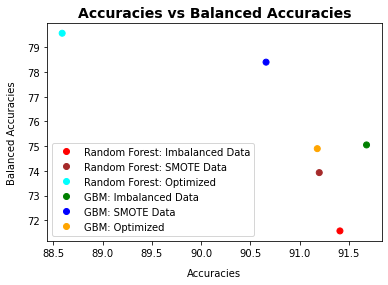

In [94]:
x = modelsDf['Accuracies']
y = modelsDf['Balanced Accuracies']
classes = list(modelsDf['Models'])
values = [0, 1, 2, 3, 4, 5]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('Accuracies', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Accuracies vs Balanced Accuracies', fontweight='bold', size=14)

Text(0.5, 1.0, 'f1-Scores vs Balanced Accuracies')

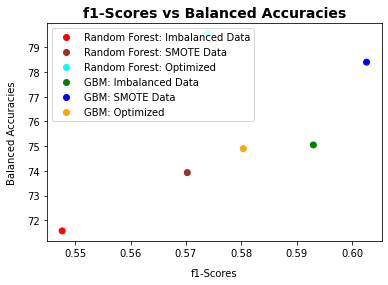

In [106]:
x = modelsDf['f1-Scores']
y = modelsDf['Balanced Accuracies']
classes = list(modelsDf['Models'])
values = [0, 1, 2, 3, 4, 5]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('f1-Scores', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('f1-Scores vs Balanced Accuracies', fontweight='bold', size=14)

## References

* https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
* https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
* https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/
* https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
